# SST (Spatial Stress Test) Behavioral Analysis

This code is designed to extract the relevant nav data from log files. Info includes events of interest (orientation, task assignment, navigation, goal arrival, shocks), button presses (up, left, right keys down/up), as well as down-sampled (500ms rate) position (x,y coordinates), heading direction, and button box inputs (holding down up/left/right buttons).

- This is just for the fMRI task, so onsets are determined (relative to scan trigger, and subtracting 8 s to allow for dropping of 4 TRs of data; `time_adj`). Crashes are dealt with by incrementing run numbers. Also deals with repeated "ARRIVED" flags (e.g., removes running into sub-goals, takes the first time point when arriving at goal). Prints out some flags/info from each subject's data file.

- Log files were updated for crashes so that crashed environments not included; should we exclude these TRs from the data files? Similarly for one subj where env was re-run accidentally -- remove from the beginning of that run?

In [1]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
import ipywidgets
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
# %load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

v2


In [177]:
def downsample_sec_reindex(df, rate='500L'):
    '''Downsamples dataframe, assuming has column time in seconds, and then goes back to original index'''
    
    # Downsample
    df['s'] = pd.to_datetime(df.time, unit='s') # convert time to pandas "time"
    df = df.resample('500L', on='s').first() # take the first sample; this conserves non-numeric cols
    df.dropna(inplace=True)

    # reindex
    df['index'] = df['index'].astype(int)
    df = df.set_index('index')
    
    return df

### Set up directories & exp-specific information

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['navdir'] = op.join('/Volumes/group/awagner/sgagnon/SST/nav_data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['navdir'], 'analysis', 'subj_info.csv')
dirs['shortcut_file'] = op.join(dirs['navdir'], 'analysis','shortcut_coords.csv')
dirs['order_file'] = op.join(dirs['navdir'], 'analysis','SST_env_order.csv')

In [3]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

v2


### Read in subject information

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info.group.value_counts()

stress     21
control    20
Name: group, dtype: int64

In [ ]:
shortcut_coords = pd.read_csv(dirs['shortcut_file'])

trial_order = pd.read_csv(dirs['order_file'])
trial_order[['subid']] = trial_order[['subid']].astype(str)

## Read in/concatenate data files

#### Only need to run this if first time:

In [249]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
n_runs = 12

test_types = ['habit', 'shortcut']

# iterate through subjects
# for subid in subj_info.subid:
for subid in subj_info.subid[:37]:
# for subid in ['39', '40']:
    print subid
    
    if test:
        d2 = pd.DataFrame() # dataframe of test files for a subj
        
        crash_subject = False # set flag for whether crash subject (more than 12 runs)
        crash_num = 0 

        # iterate through environments
        for run_num in range(1, n_runs+1):

            # deal w/num -> str IDs
            if int(subid) < 10:
                sub_str = 'sst0'
            else:
                sub_str = 'sst'

            # add test file
            test_files = glob.glob(op.join(dirs['navdir'], sub_str + str(subid), 
                                           'run'+ str(run_num),
                                           'session_*', 'log.txt'))

            # get all files, including crashes where 2 files/run
            # note that grouping files into same "run" if a crash to merge with env order; 
            # however, scan runs need to be incremented based on number of crashes
            for i, test_file in enumerate(test_files):

                if i > 0: 
                    print '***** something happened, '+str(i+1)+' files for run ' +str(run_num)+'! *****'
                    crash_subject = True
                    crash_num += 1
                    print 'Crash #: ' + str(crash_num)

                output = []
                with open(test_file) as f:
                    data = f.readlines()

                    for line in data:
                        columns = re.split('\t|\r|\n', line)
                        output.append(columns)

                d1 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                     'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

                # include subid and env
                d1['subid'] = subid
                d1['run'] = run_num # matching w/env order file
                d1['scan'] = run_num + crash_num # matching w/fMRI data

                if run_num < 5:
                    d1['type'] = 'habit'
                else:
                    d1['type'] = 'shortcut'

                # force time to in seconds, relative to beginning of session
                d1.time = d1.time.astype(int)/1000

                if (run_num == 1) & (i == 0):
                    session_start = d1.time.min()
                d1.time = d1.time - session_start

                # calculate time relative to scan start - 8 # adjust for tossed volumes (4 TRs, 8 s (2s TR))
                run_scan_trigger = d1.loc[d1.command == 'SCAN', 'time'].values[0]
                d1['time_adj'] = d1.time - run_scan_trigger - 8

                # Append to subj's dataframe
                d2 = d2.append(d1, ignore_index=True)

        d2 = d2.loc[d2.command.isin(['VROBJECT_POS', 'VROBJECT_HEADING', 'INPUT_EVENT',
                                     'KEYBOARD_UP', 'KEYBOARD_DOWN',
                                     'ORIENT', 'ARRIVED', 'ASSIGNED', 'NAVIGATE', 
                                     'SCAN', 'SHOCK'])]
        d2.drop(['c2', 'c5', 'c6', 'c7', 'c8'], axis=1, inplace=True) #unneeded cols

        # Any runs without 3 trials?
        counts = pd.groupby(d2.loc[d2.command == "ORIENT"], by=['subid', 'run']).count().reset_index()
        print counts[['subid', 'run', 'type']]
        if counts[counts.command != 3].shape[0] > 0: print 'Don''t have 3 trials for a run!'

        # Get orient onsets, for trial parsing
        d2.sort_values(by='time', inplace=True) # make sure sorted by time! this can be weird w/crashes
        orient_onsets = d2.loc[d2.command == "ORIENT"]
        orient_onsets['trial'] = 0 # init trial number

        # figure out time relative to scan trigger
        scan_triggers = d2.loc[d2.command == 'SCAN']
        if scan_triggers.shape[0] != 12: print '**** '+str(scan_triggers.shape[0])+' SCAN TRIGGERS! ****'

        # assign trial numbers
        for counter, ind in enumerate(orient_onsets.index):
            if counter == 0: # first trial
                first_ind = ind
                orient_onsets.loc[ind, 'trial'] = 1
                prev_ind = ind
            else:
                if orient_onsets.loc[ind, 'run'] == orient_onsets.loc[prev_ind, 'run']:
                    orient_onsets.loc[ind, 'trial'] = orient_onsets.loc[prev_ind, 'trial'] + 1
                    prev_ind = ind
                else:
                    orient_onsets.loc[ind, 'trial'] = 1
                    prev_ind = ind

        orient_onsets = orient_onsets.reset_index().merge(trial_order)

        d2['env'] = np.nan
        d2['rep'] = np.nan
        d2['trial'] = np.nan

        for i in orient_onsets.index:
            index_val = orient_onsets.loc[i, 'index']
            d2.loc[index_val, 'env'] = 'env' + orient_onsets.loc[i, 'env'].astype(str)
            d2.loc[index_val, 'rep'] = orient_onsets.loc[i, 'rep']
            d2.loc[index_val, 'trial'] = orient_onsets.loc[i, 'trial']

        d2.env.fillna(method='ffill', inplace=True)
        d2.rep.fillna(method='ffill', inplace=True)
        d2.trial.fillna(method='ffill', inplace=True)

        d2 = d2.loc[~d2.env.isnull()]

        print 'subj d2 shape:' + str(d2.shape)
        print len('env' + orient_onsets.env.astype(str))
        print len(d2.loc[orient_onsets['index'], 'env'])

        # Experiment trial-segment onsets
        ####################################
        onset_times = d2.loc[d2.command.isin(['ORIENT', 'ASSIGNED', 'NAVIGATE', 'SHOCK'])]
        
        # prune "ARRIVED" if not to a target (eg if run into sub-goal)
        targets = ['zzz', 'Jim_Parsons', 'Beyonce', 'Paul_McCartney', 
                   'Natalie_Portman', 'Benedict_Cumberbatch',
                   'Taylor_Swift', 'Katy_Perry', 'Johnny_Depp', 
                   'Zooey_Deschanel', 'George_Clooney', 'Mark_Zuckerberg','Emma_Watson']
        
        arrived_times = d2.loc[(d2.command == 'ARRIVED') & (d2.c3.isin(targets))]
        
        # Only use first "ARRIVED" for a target (some generate a bunch)
        onset_times = onset_times.append(arrived_times.loc[arrived_times.groupby(['run', 'trial'])["time"].idxmin()])
             
        # Figure out if each critical command doesn't have 3 trials
        critical_commands = ['ORIENT', 'ASSIGNED', 'NAVIGATE', 'ARRIVED']
        n_env_not3trials = sum(onset_times.loc[onset_times.command.isin(critical_commands)].groupby(['env', 'command']).count().trial != 3)
        if n_env_not3trials > 0: 
            print str(float(n_env_not3trials)/len(critical_commands)) + ' environments don''t have 3 trials.'
#             print onset_times.groupby(['env', 'command']).count()
            
        # Number of shocks
        print str(d2.loc[d2.command.isin(['SHOCK'])].shape[0]) + ' shocks.'

        # keyboard events
        keyboard_events = d2.loc[d2.command.isin(['KEYBOARD_DOWN', 'KEYBOARD_UP'])]

        # Get 2D position in space
        #######################################
        dp = d2.loc[d2.command == 'VROBJECT_POS'].reset_index()
        coordinates = pd.DataFrame(dp.c4.str.split('Point3|, |\(|\)').tolist())[[2, 3, 4]]
        coordinates.rename(columns={2: 'x', 3: 'y', 4: 'z'}, inplace=True)

        dp = dp.join(coordinates)
        dp[['x', 'y', 'z']] = dp[['x', 'y', 'z']].astype(float)

        dp = downsample_sec_reindex(dp, rate='500L')
        dp = dp.loc[dp.c3 == 'PandaEPL_avatar'] # remove positions that aren't actually navigator

        # Get heading direction
        #######################################
        dh = d2.loc[d2.command == 'VROBJECT_HEADING'].reset_index()
        dh = downsample_sec_reindex(dh, rate='500L')

        # Get input events (holding down button)
        di = d2.loc[d2.command == 'INPUT_EVENT'].reset_index()
        di = downsample_sec_reindex(di, rate='500L')

        # Re-combine dataframes
        data = pd.concat([onset_times, keyboard_events, dp, dh, di]).sort_index()
        print 'subj data (downsampled) shape:' + str(data.shape)

        # Append to group data
        df = df.append(data, ignore_index=True)
        print 'Group df shape: ' + str(df.shape)
        print '_______________________________________'


3
   subid  run  type
0      3    1     3
1      3    2     3
2      3    3     3
3      3    4     3
4      3    5     3
5      3    6     3
6      3    7     3
7      3    8     3
8      3    9     3
9      3   10     3
10     3   11     3
11     3   12     3


/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


subj d2 shape:(259271, 12)
36
36
0 shocks.
subj data (downsampled) shape:(11639, 16)
Group df shape: (11639, 16)
_______________________________________
4
   subid  run  type
0      4    1     3
1      4    2     3
2      4    3     3
3      4    4     3
4      4    5     3
5      4    6     3
6      4    7     3
7      4    8     3
8      4    9     3
9      4   10     3
10     4   11     3
11     4   12     3
subj d2 shape:(236330, 12)
36
36
0 shocks.
subj data (downsampled) shape:(8641, 16)
Group df shape: (20280, 16)
_______________________________________
5
   subid  run  type
0      5    1     3
1      5    2     3
2      5    3     3
3      5    4     3
4      5    5     3
5      5    6     3
6      5    7     3
7      5    8     3
8      5    9     3
9      5   10     3
10     5   11     3
11     5   12     3
subj d2 shape:(211058, 12)
36
36
0 shocks.
subj data (downsampled) shape:(8579, 16)
Group df shape: (28859, 16)
_______________________________________
6
   subid  run  ty

## Look at data

#### Prune down the data (>13 million rows beforehand)

In [251]:
filename = '/Volumes/group/awagner/sgagnon/SST/nav_data/group_fmri_onsets.h5'
df.to_hdf(filename, 'df', mode='w', format='fixed')

In [252]:
filename = '/Volumes/group/awagner/sgagnon/SST/nav_data/group_fmri_onsets.h5'
df_in = pd.read_hdf(filename, 'df')
df_in.shape

(339090, 16)

### Plot

- Subject 11 is missing evns 8 and 9 (run 2 of habit)
- Subj 14 is missing last trial of run 3 (habit); (env9) check that other 2 events are ok
- Subj 20 is missing 2nd rep through envs 10-12

In [253]:
df_in = data

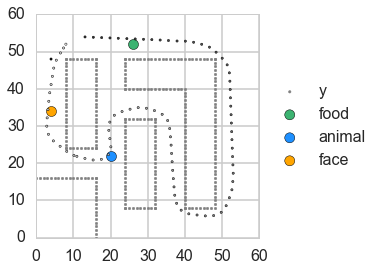

In [254]:
def plot_sub(subj, env, test_trial, rep):
    plot_paths(env=env, subj=subj, 
               dp=df_in.loc[(df_in['type'] == test_trial) &
                            (df_in.rep == rep)], 
               proj=proj, dirs=dirs)
    
subj_opts = ipywidgets.Select(options=list(df_in.subid.unique()))
env_opts = ipywidgets.ToggleButtons(options=list(np.sort(df_in.env.unique())))
test_opts = ipywidgets.ToggleButtons(options=list(['habit', 'shortcut']))
rep_opts = ipywidgets.IntSlider(min=1, max=2)

w = ipywidgets.interact(plot_sub, 
                        subj=subj_opts, 
                        env=env_opts, 
                        test_trial=test_opts, 
                        rep=rep_opts)

- 20: has 3 reps of envs 4-6, and doesn't have 2nd rep of envs 10-12
- 40 (habit, env3): loops around too many times, and wrong env? [looks like ran through envs 4,5,3, crashed on 3, and then restarted to run through 5 and 3 again. Removed run 3 from first log file, and run 5 from 2nd log file (but keep beginning of log file to have right number of cols) -- kept SCAN too, to determine onset times]
- 38 
    - (shortcut 1, env8, 9): wrong map? [appears to be env7 run crashed partway through, then restarted and ran again -- moved the initial env7 to main sst38 folder, append run_5 to start]
    - (shortcut 1, env7): didn't end?
    - (habit, env11, env6): wrong env? [town 7 was repeated twice, so moved first iteration log file/dir out into main sst38 folder, append run_4 to start]